In [1]:
import random
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras import models
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_DIR = './data/pre/train_images/'
TEST_DIR = './data/pre/test_images/'
ROOT_DIR = './data/pre/'
MODELS_DIR = './TempModels/2'

TRAIN_DF = pd.read_csv('./data/pre/train.csv')
TEST_DF = pd.read_csv('./data/pre/test.csv')

CNTS = np.array([[1443, 362],
                 [295, 75],
                 [799, 200],
                 [154, 39],
                 [235, 60]])

In [2]:
def GetSingleClass(df,c,n):
    lx = (df['class'] == c) & (df['type'] == 0)
    res = list(df[lx]['filename'].to_numpy())
    if lx.sum() > n:
        return res[:n]
    m = n - lx.sum()
    lx = (df['class'] == c) & (df['type'] != 0)
    lst = list(df[lx].sort_values(by='type')['filename'].to_numpy())
    res += lst[:m]
    return res
    
def GetClassesElements(df,cv,nv):
    res = []
    for i in range(len(cv)):
        res += GetSingleClass(df,cv[i],nv[i])
    return res

def ModifyDataFrame(df,cv,nv):
    fv1 = GetClassesElements(df,cv[0],nv[0])
    fv2 = GetClassesElements(df,cv[1],nv[1])
    df = pd.DataFrame({'filename' : fv1 + fv2, 'class' : ['0']*len(fv1) + ['1']*len(fv2)})
    return df
        
def GetGenerator(df,rootdir,bs = 32,shuffle = True):
    if shuffle is True:
        for i in range(100):
            df = df.sample(frac = 1).reset_index(drop=True)
    gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
    tr_gen = gen.flow_from_dataframe(df,target_size = (IMG_SIZE, IMG_SIZE),directory = rootdir,
                                     class_mode = 'binary', shuffle = shuffle,batch_size = bs) 
    return tr_gen

def SaveModel(model,name):
    path = os.path.join(MODELS_DIR,name)
    for suf in [''] + [str(i) for i in range(256)]:
        modified_path = path + suf
        if not os.path.exists(modified_path):
            os.makedirs(modified_path)
            path = modified_path
            break
    model.save(path)
    return path

def draw_evolution(history):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for hist in history:
        acc += hist.history['accuracy']
        val_acc += hist.history['val_accuracy']
        loss += hist.history['loss']
        val_loss += hist.history['val_loss']
    print('Test: Accuracy mean/std - {}/{}'.format(np.mean(np.array(val_acc)),np.std(np.array(val_acc))))
    print('Test: Loss mean/std - {}/{}'.format(np.mean(np.array(val_loss)),np.std(np.array(val_loss))))
    print('Train: Accuracy mean/std - {}/{}'.format(np.mean(np.array(acc)),np.std(np.array(acc))))
    print('Train: Loss mean/std - {}/{}'.format(np.mean(np.array(loss)),np.std(np.array(loss))))
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Found 10 validated image filenames belonging to 2 classes.


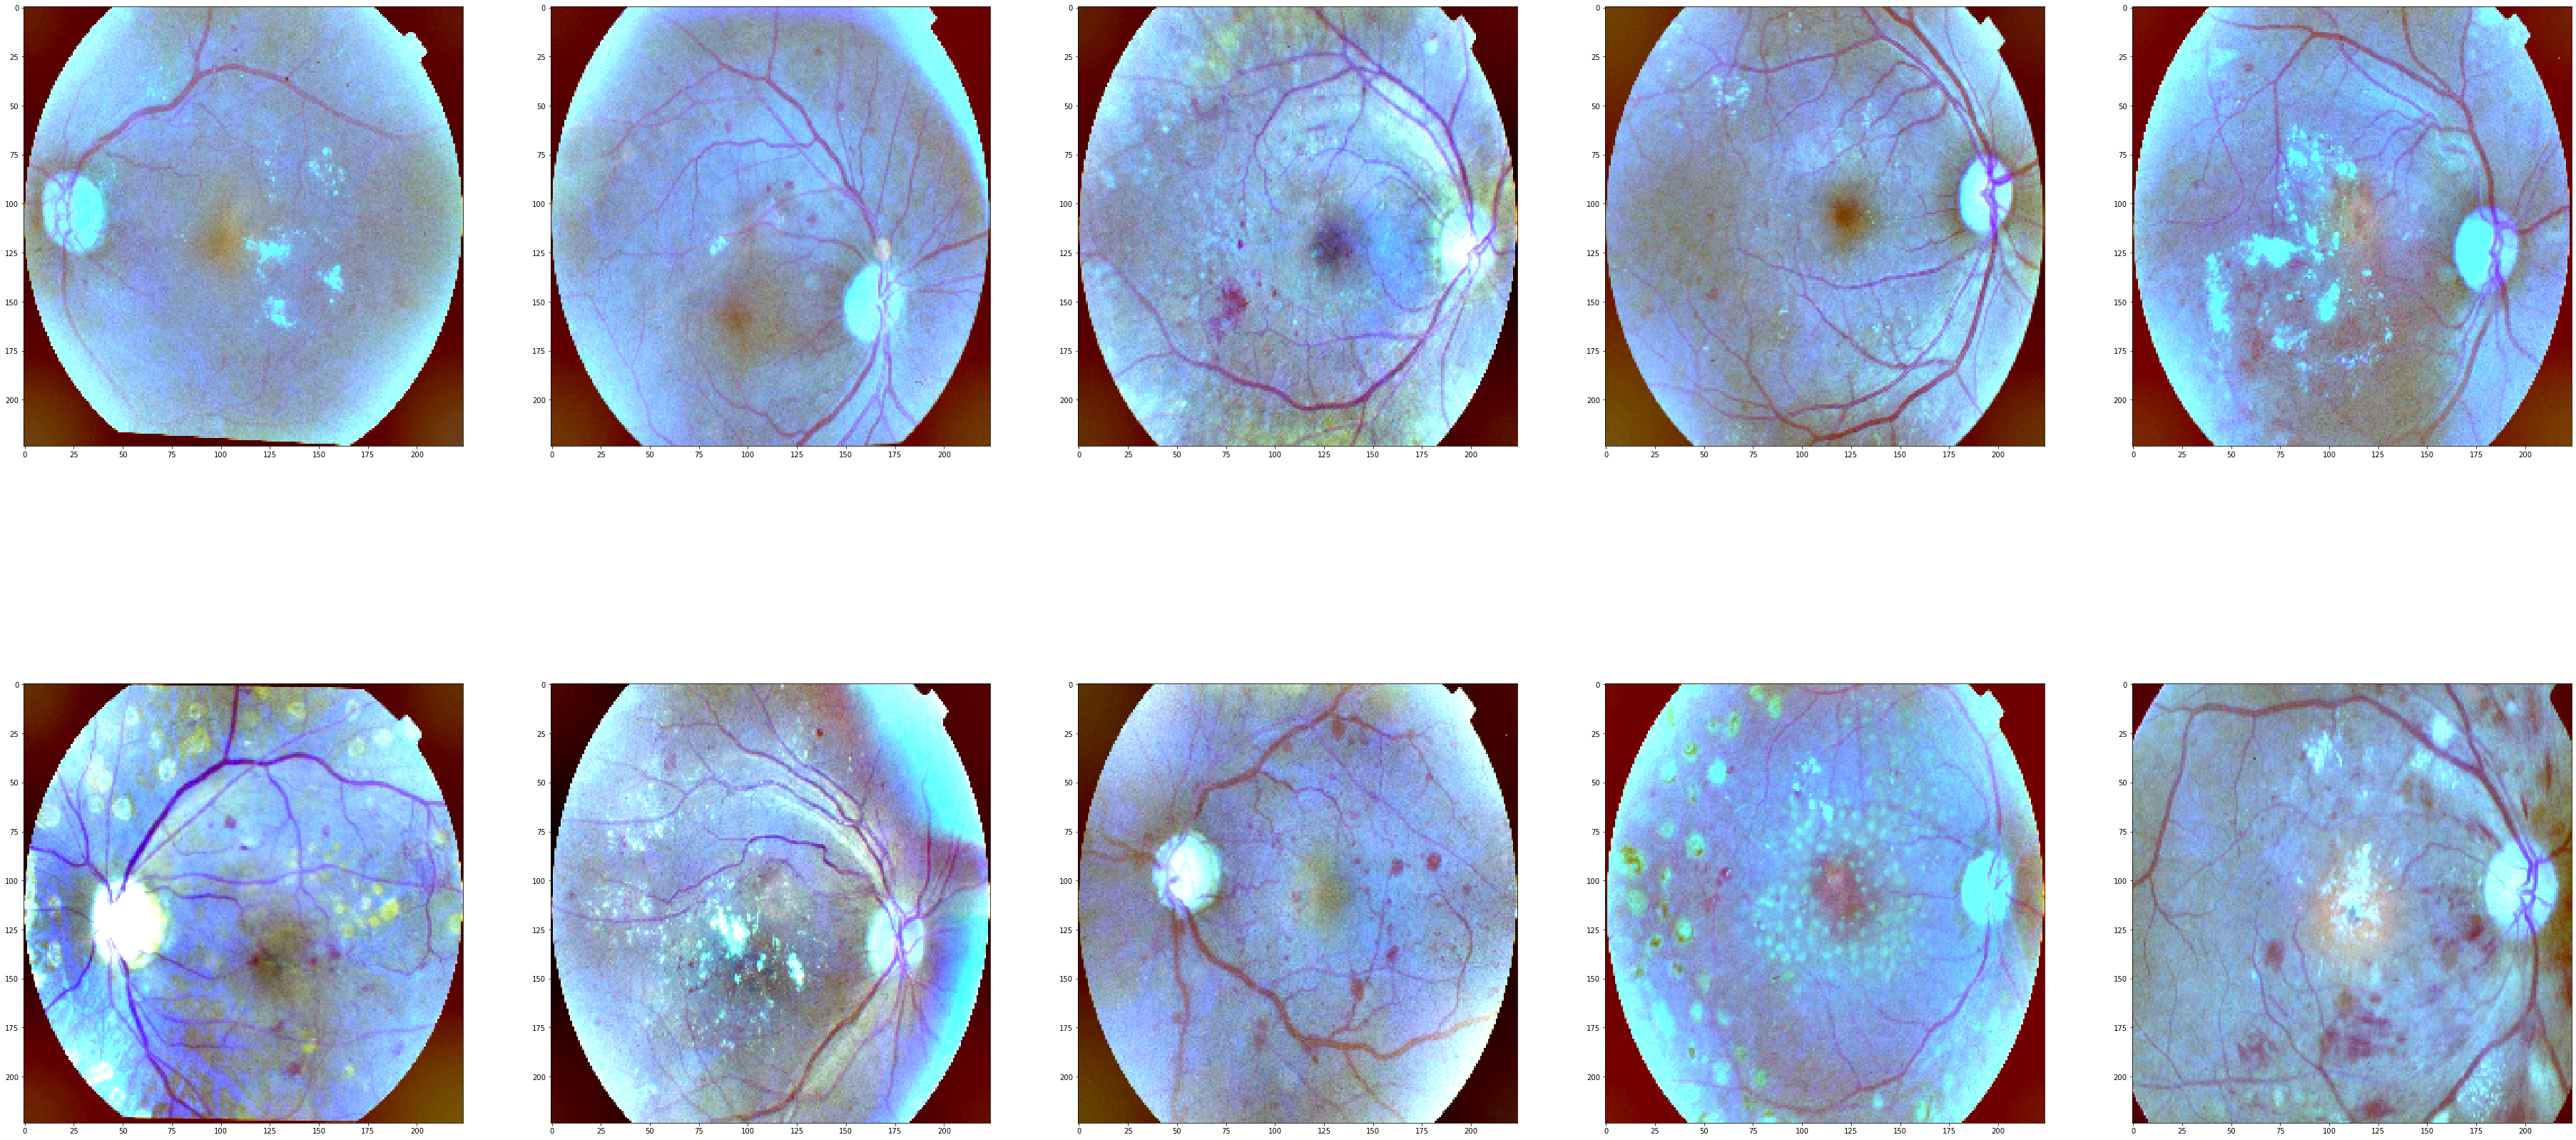

In [9]:
df = TRAIN_DF.copy()
df = df.sample(frac = 1).reset_index(drop=True)
img_set = [[2],[3]]
img_cnts = [[5],[5]]
chk_df = ModifyDataFrame(df,img_set,img_cnts)
gen = GetGenerator(chk_df,TRAIN_DIR,bs = 10,shuffle = False)
sz = 32
fig = plt.figure(figsize=(64, 32))
# display 10 images from each class
ff = iter(gen).next()
imgs = ff[0].reshape((2,5,224,224,3))
for x in range(2):
    for y in range(5):
        fig.add_subplot(2, 5, x * 5 + y + 1)
        #image = cv2.resize(imgs[x,y,:,:,:],(sz,sz))
        image = imgs[x,y,:,:,:]
        plt.imshow(image)

In [21]:
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

Found 10 validated image filenames belonging to 2 classes.


In [47]:
v = np.array([1,2,3,4,5,6,7,8,9,10]).reshape(2,5)
v

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)

In [119]:
CNTS

array([[1443,  362],
       [ 295,   75],
       [ 799,  200],
       [ 154,   39],
       [ 235,   60]])

In [132]:
train_batch_size = 64
train_set = [[2],[3,4]]
train_cnts = [[799], [399,400]]
#train_cnts = [[799], [154,235]]
train_cnt = np.array([x for y in train_cnts for x in y]).sum()
train_df = ModifyDataFrame(TRAIN_DF,train_set,train_cnts)
train_gen = GetGenerator(train_df,TRAIN_DIR,bs = train_batch_size)

test_batch_size = 32
test_set = [[2],[3,4]]
test_cnts = [[100], [39,60]]
test_cnt = np.array([x for y in test_cnts for x in y]).sum()
test_df = ModifyDataFrame(TEST_DF,test_set,test_cnts)
test_gen = GetGenerator(test_df,TEST_DIR,bs = test_batch_size)

Found 1598 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [133]:
eval_set = [[2],[3,4]]
eval_cnts = [[200], [39,60]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen1 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[3,4]]
eval_cnts = [[100],[39,60]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen2 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[3]]
eval_cnts = [[39],[39]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen3 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[4]]
eval_cnts = [[60],[60]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen4 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[3],[4]]
eval_cnts = [[39],[39]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen5 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

Found 299 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [162]:
def create_model(d0 = 32, cn = 5, dl = 512, r = 0.0001, l2 = None, dp = None,name = None):
    if name is None:
        model = models.Sequential()
    else:
        model = models.Sequential(name = name)
    deep = d0
    for i in range(cn):
        model.add(layers.Conv2D(deep, (3,3), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
        model.add(layers.MaxPooling2D((2,2)))
        deep = deep * 2
    model.add(layers.GlobalAveragePooling2D())
    #model.add(layers.Flatten())
    if dp is not None:
        model.add(layers.Dropout(dp))
    if l2 is not None:
        model.add(layers.Dense(dl, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.001)))
    else:
        model.add(layers.Dense(dl, activation = 'relu')) 
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=r),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

#model = create_model(32,5,dl = 256,r = 0.001)
#model.summary()

In [177]:
rs = [0.0001, 0.0003, 0.0006, 0.0009, 0.001]
dl = [256, 512,1024]
model = create_model(32,5,dl = 1024,r = 0.0003,name = 'dummy_name222')

In [178]:
SaveModel(model,model.name)

INFO:tensorflow:Assets written to: ./TempModels/2\dummy_name222\assets


'./TempModels/2\\dummy_name222'

In [152]:
start = time.time()
rs = [0.0001, 0.0003, 0.0006, 0.0009, 0.001]
dl = [256, 512,1024]
histrories = dict()
for l in dl:
    for r0 in rs:
        if l == 256:
            if r0 == 0.0001 or r0 == 0.0003:
                continue
        if l == 1024 and r0 == 0.0003:
            continue
        mname = 'Model2_r{}_l{}_ep120_bch64'.format(r0,l)
        model = create_model(32,5,dl = l,r = r0,name = mname)
        history = []
        for i in range(120):
            print('Iteration - {}'.format(i))
            train_gen = GetGenerator(train_df,TRAIN_DIR,bs = train_batch_size)
            hist = model.fit(train_gen,
                                steps_per_epoch = int(0 != train_cnt % train_batch_size) + train_cnt//train_batch_size,
                                epochs = 1,
                                validation_data = eval_gen2,
                                validation_steps = 1)
            vall = hist.history['val_accuracy'][0]
            if vall >= 0.70:
                name_of_model = 'Model2_r{}_l{}_ep{}_bch64_b{}'.format(r0,l,i,int(100 * vall))
                SaveModel(model,name_of_model)
            history.append(hist)
        SaveModel(model,model.name)
        histories[model.name] = history
elapsed_time = time.time() - start
#int(0 != test_cnt//test_batch_size) + test_cnt//test_batch_size
print(elapsed_time)

Iteration - 0
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 149s 6s/step - loss: 0.6941 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Iteration - 1
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 147s 6s/step - loss: 0.6916 - accuracy: 0.5313 - val_loss: 0.6905 - val_accuracy: 0.5126
Iteration - 2
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 145s 6s/step - loss: 0.6765 - accuracy: 0.5801 - val_loss: 0.6846 - val_accuracy: 0.5628
Iteration - 3
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 143s 6s/step - loss: 0.6566 - accuracy: 0.6076 - val_loss: 0.6778 - val_accuracy: 0.5779
Iteration - 4
Fo

Train for 25 steps, validate for 1 steps
25/25 [==============================] - 156s 6s/step - loss: 0.3789 - accuracy: 0.8260 - val_loss: 0.7388 - val_accuracy: 0.6080
Iteration - 34
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 150s 6s/step - loss: 0.3510 - accuracy: 0.8473 - val_loss: 0.6506 - val_accuracy: 0.6583
Iteration - 35
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 149s 6s/step - loss: 0.3869 - accuracy: 0.8210 - val_loss: 0.6601 - val_accuracy: 0.6332
Iteration - 36
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 149s 6s/step - loss: 0.3651 - accuracy: 0.8298 - val_loss: 0.6695 - val_accuracy: 0.6683
Iteration - 37
Found 1598 validated image filenames belonging to 2 classes.
Train for 25

25/25 [==============================] - 159s 6s/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 1.3191 - val_accuracy: 0.6935
Iteration - 100
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 161s 6s/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 1.3639 - val_accuracy: 0.6834
Iteration - 101
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 165s 7s/step - loss: 0.0356 - accuracy: 0.9906 - val_loss: 1.3995 - val_accuracy: 0.7035
Iteration - 102
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [==============================] - 161s 6s/step - loss: 0.0292 - accuracy: 0.9925 - val_loss: 1.1617 - val_accuracy: 0.7035
Iteration - 103
Found 1598 validated image filenames belonging to 2 classes.
Train for 25 steps, validate for 1 steps
25/25 [=

Test: Accuracy mean/std - 0.668121874332428/0.050727479159832
Test: Loss mean/std - 1.101547484844923/0.34699296148957665
Train: Accuracy mean/std - 0.9185739755630493/0.11052185297012329
Train: Loss mean/std - 0.17225113678067644/0.19919435663426394


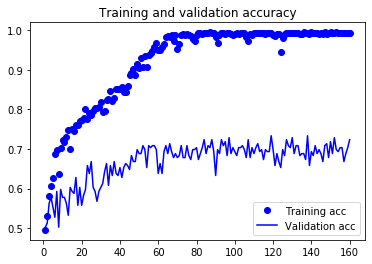

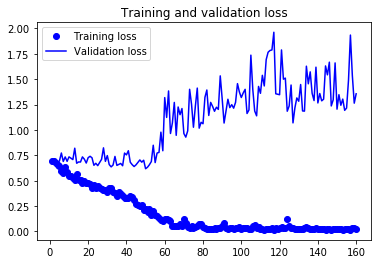

In [156]:
draw_evolution(history)

In [153]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.5484 - accuracy: 0.4872


[3.54839825630188, 0.4871795]

In [157]:
name_of_model = 'Model2_r0003_ep160h64_a74_b72_c74_d70_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0003_ep160h64_a74_b72_c74_d70_e48\assets


'./TempModels/2\\Model2_r0003_ep160h64_a74_b72_c74_d70_e48'

Test: Accuracy mean/std - 0.5906298756599426/0.03751164302229881
Test: Loss mean/std - 0.8361543079819342/0.20205733115620875
Train: Accuracy mean/std - 0.8149074912071228/0.09531571716070175
Train: Loss mean/std - 0.3794502375309965/0.14794163802717827


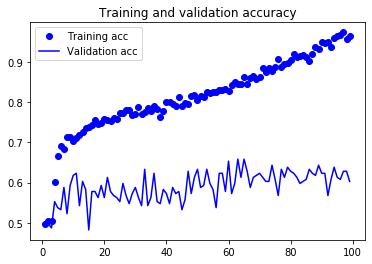

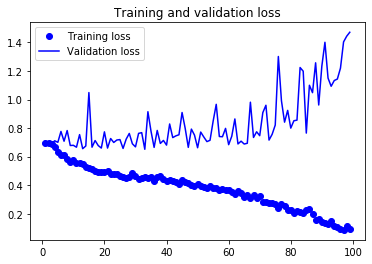

In [149]:
draw_evolution(history)

In [147]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.2548 - accuracy: 0.4103


[3.254765033721924, 0.41025642]

In [148]:
name_of_model = 'Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41\assets


'./TempModels/2\\Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41'

Test: Accuracy mean/std - 0.6220895051956177/0.040406081825494766
Test: Loss mean/std - 0.7085020710660525/0.09416223295089117
Train: Accuracy mean/std - 0.8232378959655762/0.08510700613260269
Train: Loss mean/std - 0.3643739835183685/0.12743962297191178


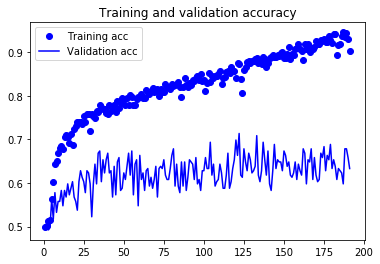

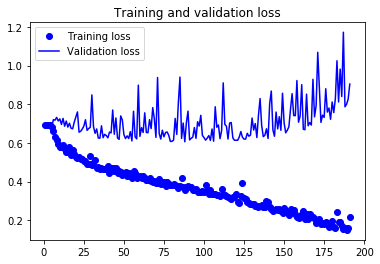

In [141]:
draw_evolution(history)

In [142]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 1.8128 - accuracy: 0.4487


[1.8127896785736084, 0.44871795]

In [143]:
name_of_model = 'Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44\assets


'./TempModels/2\\Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44'

Test: Accuracy mean/std - 0.6099245548248291/0.04153493419289589
Test: Loss mean/std - 0.6813198963801066/0.06598311259407698
Train: Accuracy mean/std - 0.7779359817504883/0.07498498260974884
Train: Loss mean/std - 0.44056881849122115/0.0941113608687484


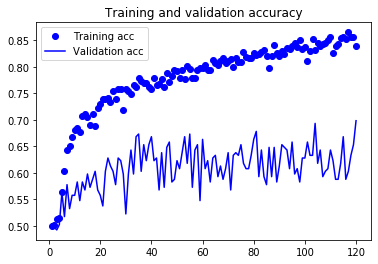

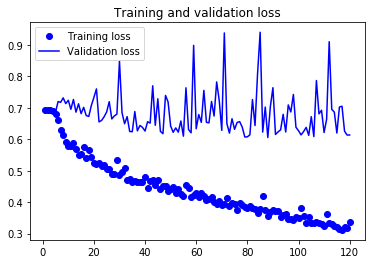

In [139]:
draw_evolution(history)

In [137]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 1.1724 - accuracy: 0.5256


[1.172392725944519, 0.525641]

In [138]:
name_of_model = 'Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52\assets


'./TempModels/2\\Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52'

Test: Accuracy mean/std - 0.586599588394165/0.05604285001754761
Test: Loss mean/std - 0.9776685694853465/0.3939285584415976
Train: Accuracy mean/std - 0.8035985231399536/0.12273361533880234
Train: Loss mean/std - 0.3967578524542828/0.21677356370151515


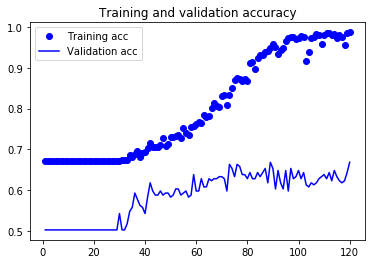

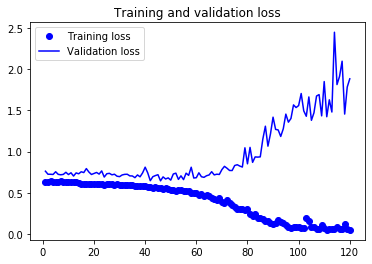

In [126]:
draw_evolution(history)

In [127]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 4.0191 - accuracy: 0.4615


[4.0190582275390625, 0.46153846]

In [ ]:
name_of_model = 'Model2_0001_ep120_bch32_a_b_c_d_e'
SaveModel(model,name_of_model)

Test: Accuracy mean/std - 0.5983425378799438/0.0441390760242939
Test: Loss mean/std - 1.1744098161396228/0.3013368071761936
Train: Accuracy mean/std - 0.8449816107749939/0.12957729399204254
Train: Loss mean/std - 0.5011485695742081/0.3970638155875498


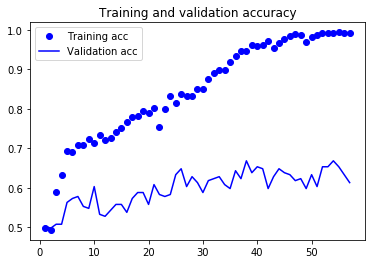

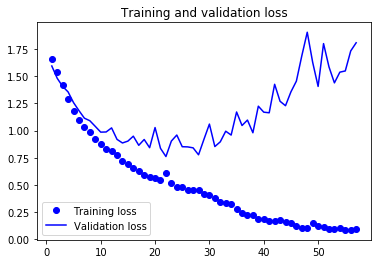

In [116]:
draw_evolution(history)

In [117]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 9s 9s/step - loss: 3.1412 - accuracy: 0.4872


[3.1411843299865723, 0.4871795]

In [118]:
name_of_model = 'Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48\assets


'./TempModels/2\\Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48'

Test: Accuracy mean/std - 0.5859041810035706/0.04644664004445076
Test: Loss mean/std - 0.831729605228086/0.18318800183069822
Train: Accuracy mean/std - 0.8167487978935242/0.09942915290594101
Train: Loss mean/std - 0.37060560821523464/0.16165127157292336


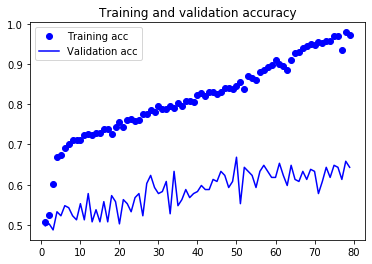

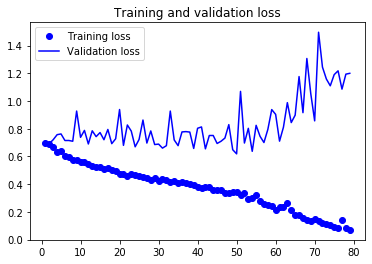

In [110]:
draw_evolution(history)

Test: Accuracy mean/std - 0.5351758003234863/0.03481173515319824
Test: Loss mean/std - 0.8684505665743792/0.21895224488986356
Train: Accuracy mean/std - 0.7148750424385071/0.15288880467414856
Train: Loss mean/std - 0.5382182844591363/0.28971108140056356


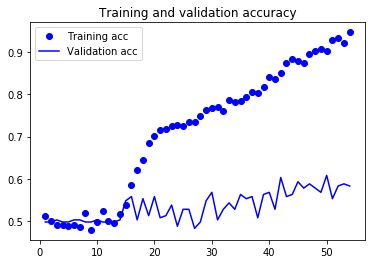

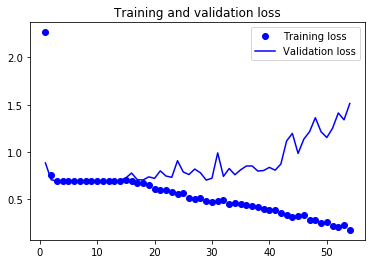

In [103]:
draw_evolution(history)

In [101]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 2.5783 - accuracy: 0.4487


[2.578274965286255, 0.44871795]

In [102]:
name_of_model = 'Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44\assets


'./TempModels/2\\Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44'

Test: Accuracy mean/std - 0.49979063868522644/0.0025038346648216248
Test: Loss mean/std - 0.693673895051082/0.0035514911273878272
Train: Accuracy mean/std - 0.490795761346817/0.00801998469978571
Train: Loss mean/std - 0.7118232926578386/0.12682884437169134


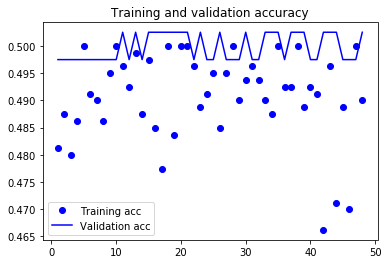

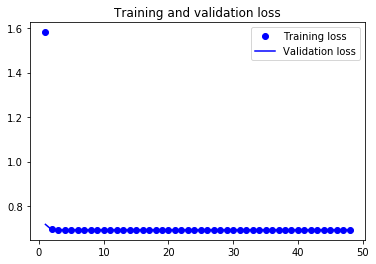

In [94]:
draw_evolution(history)

In [95]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 0.6932 - accuracy: 0.5000


[0.6931523680686951, 0.5]

In [96]:
name_of_model = 'Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50\assets


'./TempModels/2\\Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50'

Test: Accuracy mean/std - 0.552763819694519/0.03222263604402542
Test: Loss mean/std - 1.174491211771965/0.5431341012084231
Train: Accuracy mean/std - 0.8326584696769714/0.13109219074249268
Train: Loss mean/std - 0.37192179658993557/0.3336900776892232


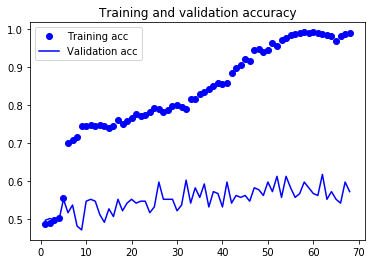

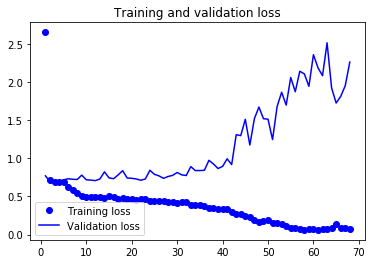

In [87]:
draw_evolution(history)

In [88]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 4.3893 - accuracy: 0.4231


[4.389348030090332, 0.42307693]

In [89]:
name_of_model = 'Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42\assets


'./TempModels/2\\Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42'

Test: Accuracy mean/std - 0.5868878960609436/0.027213871479034424
Test: Loss mean/std - 1.0438130705855613/0.27917986650181803
Train: Accuracy mean/std - 0.8811160326004028/0.10256370157003403
Train: Loss mean/std - 0.2854095466902718/0.18257638964928638


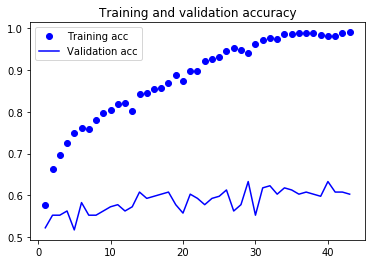

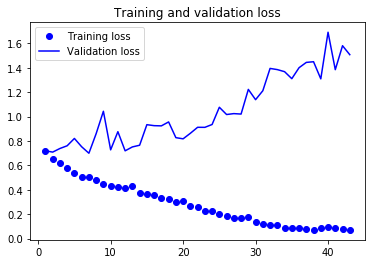

In [81]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6089614629745483/0.022871991619467735
Test: Loss mean/std - 1.3204783538977305/0.31609899811907943
Train: Accuracy mean/std - 0.9294535517692566/0.10238738358020782
Train: Loss mean/std - 0.2722271336830024/0.3674328848055607


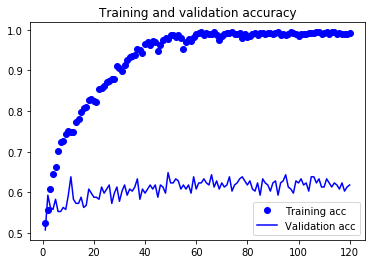

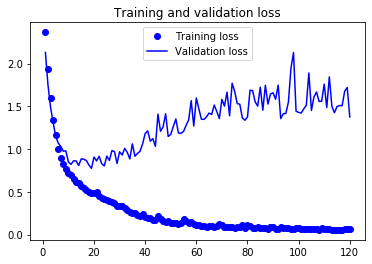

In [76]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6524706482887268/0.06236016005277634
Test: Loss mean/std - 1.623106330136458/0.5964217948171227
Train: Accuracy mean/std - 0.9248539805412292/0.11366390436887741
Train: Loss mean/std - 0.1525508192912535/0.21093590585386682


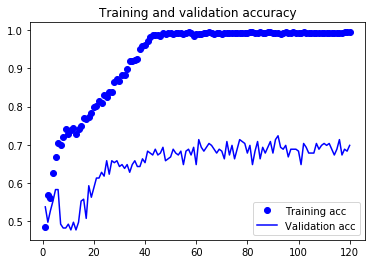

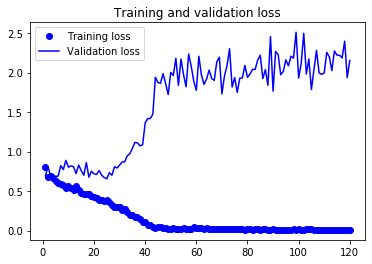

In [68]:
draw_evolution(history)

In [69]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 5.0054 - accuracy: 0.5385


[5.005425453186035, 0.53846157]

In [70]:
name_of_model = 'Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53\assets


'./TempModels/2\\Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53'

Test: Accuracy mean/std - 0.6114664673805237/0.028953952714800835
Test: Loss mean/std - 1.4932127291505988/0.4380822217664362
Train: Accuracy mean/std - 0.9457960724830627/0.09454911947250366
Train: Loss mean/std - 0.12160768793135385/0.17237581658177883


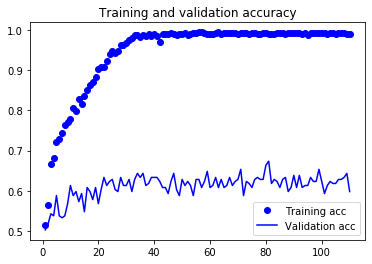

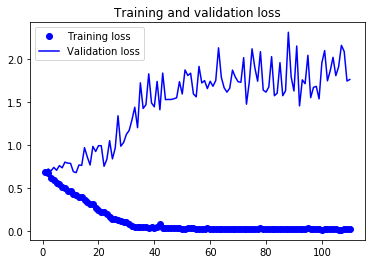

In [63]:
draw_evolution(history)

In [61]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.6431 - accuracy: 0.5000


[2.643106698989868, 0.5]

In [62]:
name_of_model = 'Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50\assets


'./TempModels/2\\Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50'

Test: Accuracy mean/std - 0.6211892366409302/0.04820884019136429
Test: Loss mean/std - 1.3614029909173648/0.49283378095782493
Train: Accuracy mean/std - 0.9115613102912903/0.10264014452695847
Train: Loss mean/std - 0.4009088981741613/2.0595187381015743


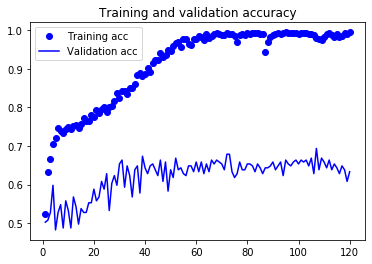

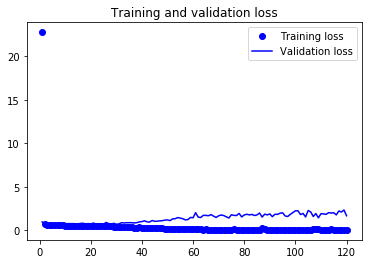

In [55]:
draw_evolution(history)

In [53]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 3.2452 - accuracy: 0.4872


[3.245234489440918, 0.4871795]

In [54]:
name_of_model = 'Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48\assets


'./TempModels/2\\Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48'

Test: Accuracy mean/std - 0.6215927004814148/0.057826802134513855
Test: Loss mean/std - 1.1550035142537318/0.4144672335079299
Train: Accuracy mean/std - 0.8790627717971802/0.12760859727859497
Train: Loss mean/std - 0.3468632749822419/0.6622850762135969


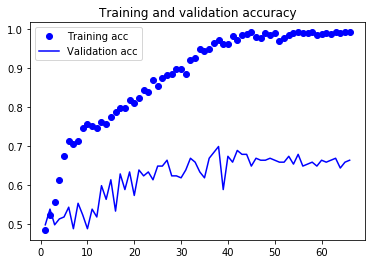

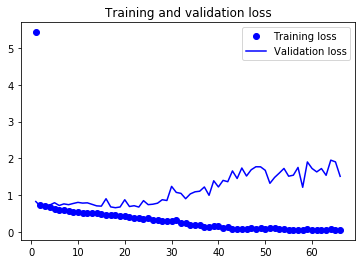

In [46]:
draw_evolution(history)

In [45]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.5073 - accuracy: 0.4872


[2.507343053817749, 0.4871795]

In [47]:
name_of_model = 'Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48\assets


'./TempModels/2\\Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48'

Test: Accuracy mean/std - 0.6012563109397888/0.05518360063433647
Test: Loss mean/std - 1.005750415722529/0.3093157645366066
Train: Accuracy mean/std - 0.8574467897415161/0.11369901895523071
Train: Loss mean/std - 0.37336463385840907/0.4177610838125139


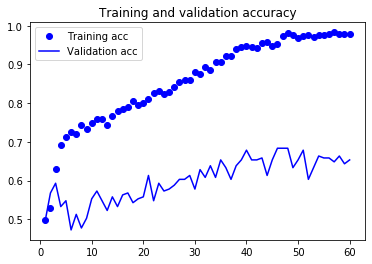

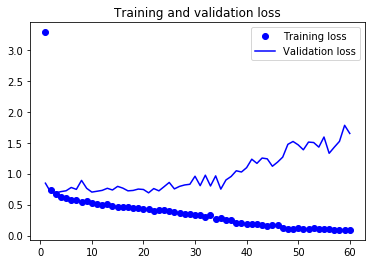

In [32]:
draw_evolution(history)

In [33]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.9987 - accuracy: 0.4872


[2.9986937046051025, 0.4871795]

In [34]:
name_of_model = 'Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48\assets


'./TempModels/2\\Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48'

Test: Accuracy mean/std - 0.5897612571716309/0.019819704815745354
Test: Loss mean/std - 1.5826368618756532/0.7406189758447715
Train: Accuracy mean/std - 0.9354153871536255/0.09928683936595917
Train: Loss mean/std - 0.35684377960251695/0.9869600483356166


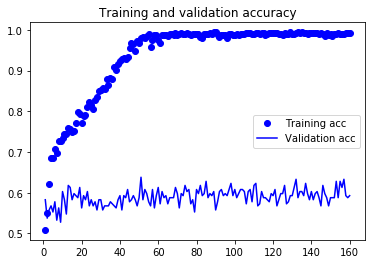

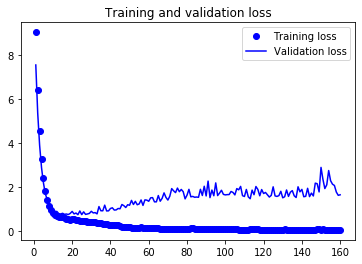

In [20]:
draw_evolution(history)

In [18]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.6591 - accuracy: 0.5256


[2.659147024154663, 0.525641]

In [19]:
name_of_model = 'Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52\assets


'./TempModels/2\\Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52'

Test: Accuracy mean/std - 0.6088358759880066/0.03253418207168579
Test: Loss mean/std - 1.4416969244678814/0.7964675169209343
Train: Accuracy mean/std - 0.9222204685211182/0.10857262462377548
Train: Loss mean/std - 0.4325836202975566/1.1091481229715983


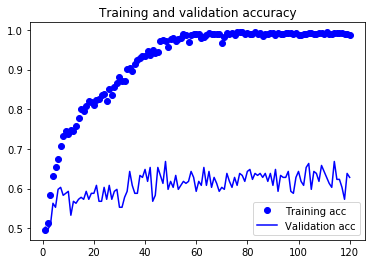

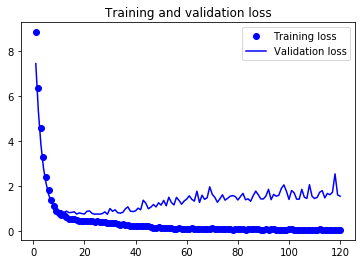

In [10]:
draw_evolution(history)

In [11]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.0111 - accuracy: 0.4872


[3.0110628604888916, 0.4871795]

In [12]:
name_of_model = 'Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48'
SaveModel(model,name_of_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48\assets


'./TempModels/2\\Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48'

# Classification 1 vs 2,3,4

Test: Accuracy mean/std - 0.5387336015701294/0.17514243721961975
Test: Loss mean/std - 1.3964285645633936/0.689374443964279
Train: Accuracy mean/std - 0.9542455673217773/0.07310210168361664
Train: Loss mean/std - 0.24904684651190703/0.8595044772008003


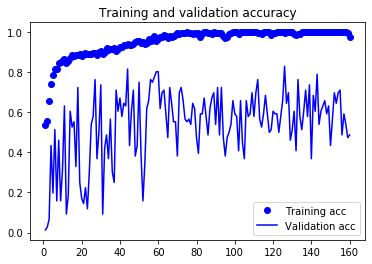

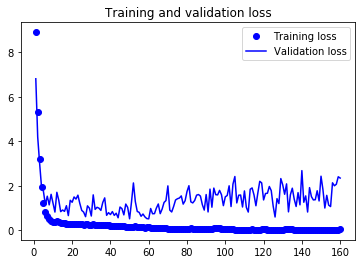

In [50]:
draw_evolution(history)

In [51]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 1.2293 - accuracy: 0.7200


[1.2292622327804565, 0.72]

In [52]:
name_of_model = 'Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72\assets


'./Models\\Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72'

Test: Accuracy mean/std - 0.6431743502616882/0.16430498659610748
Test: Loss mean/std - 1.1775646613910795/0.6101770795216177
Train: Accuracy mean/std - 0.9659274816513062/0.06871379166841507
Train: Loss mean/std - 0.21185456696650412/0.7340921912133037


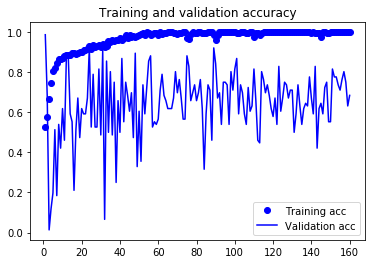

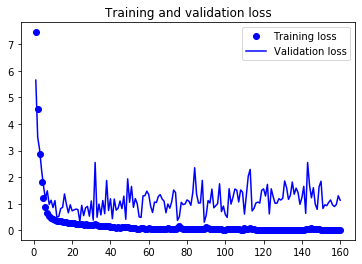

In [42]:
draw_evolution(history)

In [43]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.6922 - accuracy: 0.7933


[0.6922270655632019, 0.79333335]

In [44]:
name_of_model = 'Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79\assets


'./Models\\Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79'

Test: Accuracy mean/std - 0.6152412295341492/0.15758371353149414
Test: Loss mean/std - 1.2174039117991924/0.5081534135730513
Train: Accuracy mean/std - 0.9634925723075867/0.07128439843654633
Train: Loss mean/std - 0.19506615667698501/0.5108133634221242


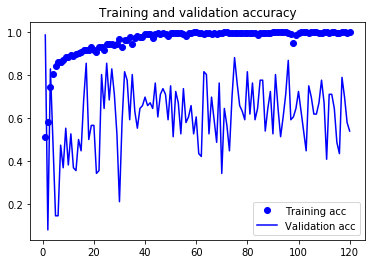

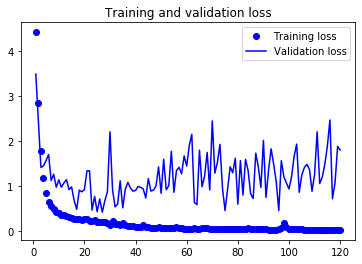

In [32]:
draw_evolution(history)

In [33]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.9449 - accuracy: 0.7533


[0.9448913931846619, 0.75333333]

In [34]:
name_of_model = 'Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75\assets


'./Models\\Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75'

Test: Accuracy mean/std - 0.5359649658203125/0.19006769359111786
Test: Loss mean/std - 1.230181399318907/0.7626317075509296
Train: Accuracy mean/std - 0.9365647435188293/0.07576955109834671
Train: Loss mean/std - 0.36994251810136897/1.0044649455238572


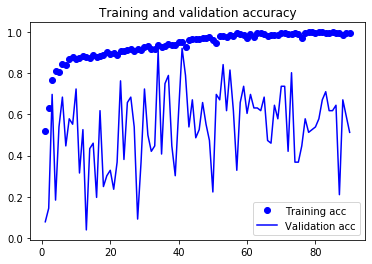

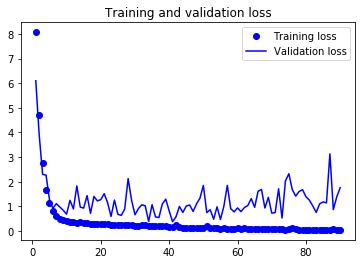

In [26]:
draw_evolution(history)

In [24]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.9497 - accuracy: 0.7333


[0.9497488141059875, 0.73333335]

In [25]:
name_of_model = 'Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73\assets


'./Models\\Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73'

Test: Accuracy mean/std - 0.44550439715385437/0.17706453800201416
Test: Loss mean/std - 1.9861971085270247/0.8037173147065116
Train: Accuracy mean/std - 0.9474571943283081/0.08296161890029907
Train: Loss mean/std - 0.1422785999793397/0.27421817312978397


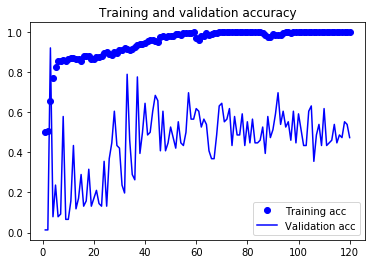

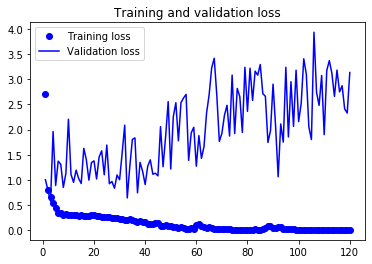

In [17]:
draw_evolution(history)

In [18]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 1.7187 - accuracy: 0.7067


[1.7187000513076782, 0.70666665]

In [19]:
name_of_model = 'Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70\assets


'./Models\\Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70'

Test: Accuracy mean/std - 0.5694078803062439/0.1660100370645523
Test: Loss mean/std - 1.2008266396820546/0.48648551887059577
Train: Accuracy mean/std - 0.9613951444625854/0.04391316697001457
Train: Loss mean/std - 0.1350420144220394/0.10484748394297974


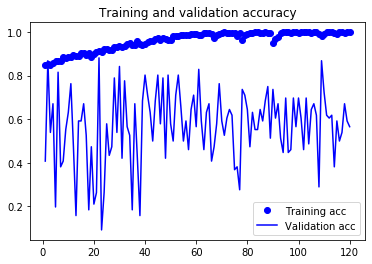

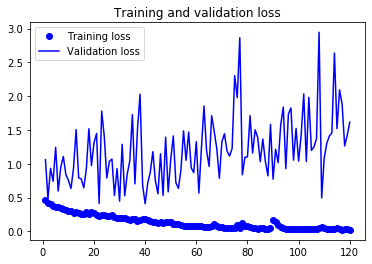

In [8]:
draw_evolution(history)

In [9]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.8810 - accuracy: 0.7467


[0.8809981942176819, 0.74666667]

In [11]:
name_of_model = 'Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74\assets


'./Models\\Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74'

In [378]:
new_model = tf.keras.models.load_model('./Models/Model5_1024_0001_l201_ep37_shuffle_bch64_b98')

In [379]:
new_model.evaluate(eval_gen1)
new_model.evaluate(eval_gen2)
new_model.evaluate(eval_gen3)
new_model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 11.4090 - accuracy: 0.5000


[11.408957481384277, 0.5]

Test: Accuracy mean/std - 0.40051349997520447/0.2544291913509369
Test: Loss mean/std - 1.6096130667663202/1.8225730207312447
Train: Accuracy mean/std - 0.8582059144973755/0.08469045162200928
Train: Loss mean/std - 1.0932941325856291/2.7187971864215426


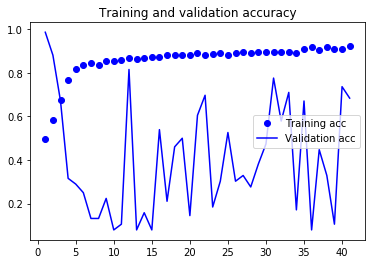

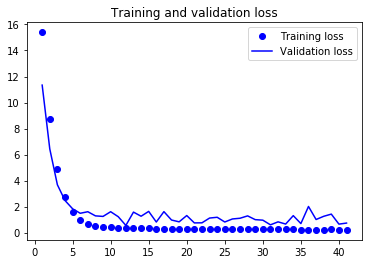

In [377]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6197535395622253/0.18997471034526825
Test: Loss mean/std - 1.1122841437028934/1.0537478996863938
Train: Accuracy mean/std - 0.9489542245864868/0.06652773171663284
Train: Loss mean/std - 0.3536261678842222/1.4538463446061392


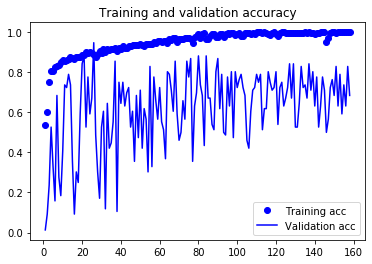

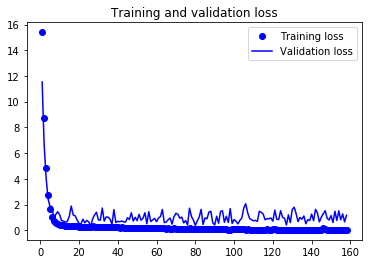

In [370]:
draw_evolution(history)

In [369]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.6412 - accuracy: 0.8000


[0.641241192817688, 0.8]

In [371]:
name_of_model = 'Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80\assets


'./Models\\Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80'

In [363]:
name_of_model = 'Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88\assets


'./Models\\Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88'

Test: Accuracy mean/std - 0.47368425130844116/0.26203709840774536
Test: Loss mean/std - 1.6890765994787216/2.2046340549681287
Train: Accuracy mean/std - 0.8451598882675171/0.081288643181324
Train: Loss mean/std - 1.420429190493259/3.1159305488219307


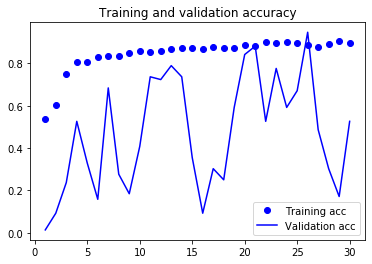

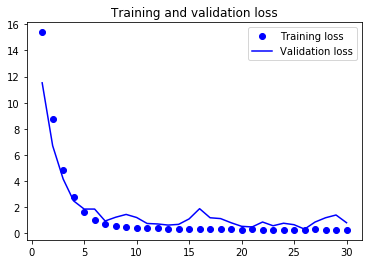

In [351]:
draw_evolution(history)

In [352]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.4865 - accuracy: 0.7267


[0.48646703362464905, 0.7266667]

In [353]:
name_of_model = 'Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72\assets


'./Models\\Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72'

Test: Accuracy mean/std - 0.41644734144210815/0.2581186890602112
Test: Loss mean/std - 2.138630124926567/2.576465903300782
Train: Accuracy mean/std - 0.8207912445068359/0.08999185264110565
Train: Loss mean/std - 1.9934246348737663/3.684896382391983


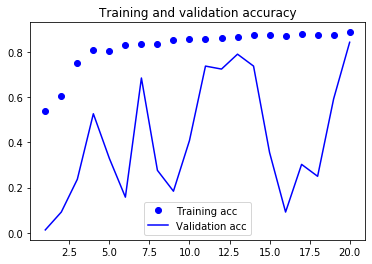

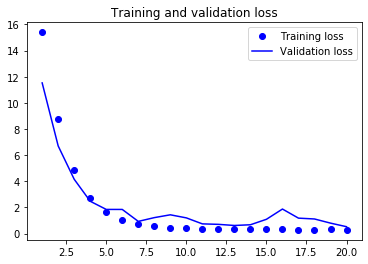

In [349]:
draw_evolution(history)

In [347]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.4361 - accuracy: 0.8533


[0.43614140152931213, 0.85333335]

In [348]:
name_of_model = 'Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85\assets


'./Models\\Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85'

Test: Accuracy mean/std - 0.5506578683853149/0.1663806140422821
Test: Loss mean/std - 1.1339775770902634/0.35942140976956094
Train: Accuracy mean/std - 0.9294542670249939/0.08605353534221649
Train: Loss mean/std - 0.2743541996608311/0.33138986394994846


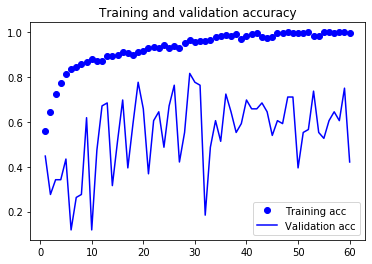

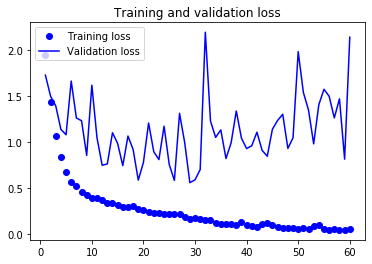

In [337]:
draw_evolution(history)

Test: Accuracy mean/std - 0.5684210062026978/0.1534799337387085
Test: Loss mean/std - 1.282803896665573/0.44895467946525514
Train: Accuracy mean/std - 0.9561912417411804/0.07440385967493057
Train: Loss mean/std - 0.18187453986355653/0.2808036854223145


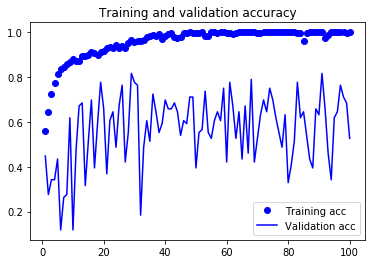

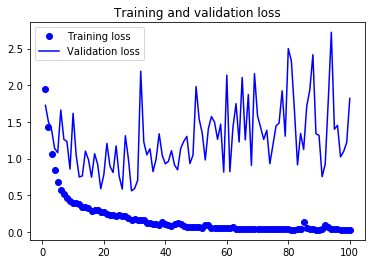

In [342]:
draw_evolution(history)

In [341]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.9634 - accuracy: 0.7400


[0.9634169936180115, 0.74]

In [343]:
name_of_model = 'Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74\assets


'./Models\\Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74'

In [338]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 1.1203 - accuracy: 0.6933


[1.1203422546386719, 0.6933333]

In [339]:
name_of_model = 'Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69\assets


'./Models\\Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69'

Test: Accuracy mean/std - 0.5220394730567932/0.1865079402923584
Test: Loss mean/std - 1.0635256797075272/0.3434277151855929
Train: Accuracy mean/std - 0.8980218768119812/0.09005864709615707
Train: Loss mean/std - 0.37431211873625564/0.3667926499227678


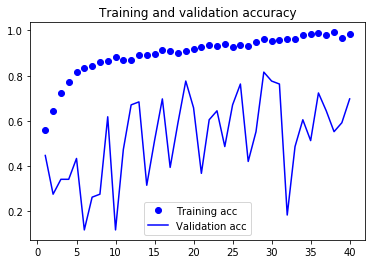

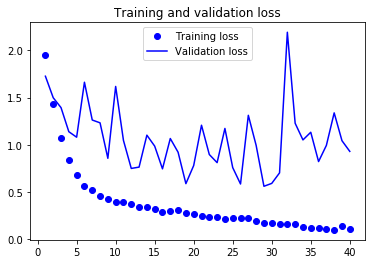

In [333]:
draw_evolution(history)

In [334]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.5603 - accuracy: 0.8067


[0.5603086352348328, 0.8066667]

In [335]:
name_of_model = 'Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80\assets


'./Models\\Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80'

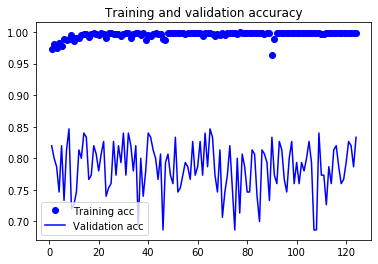

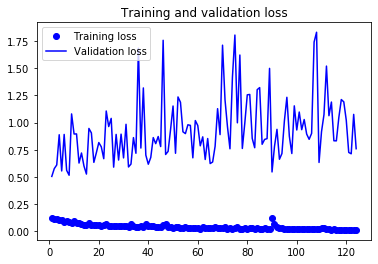

In [314]:
draw_evolution(history)

In [310]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 3s 3s/step - loss: 0.8611 - accuracy: 0.8077


[0.8610624074935913, 0.8076923]

In [313]:
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 16s 16s/step - loss: 0.8715 - accuracy: 0.7933


[0.8714727163314819, 0.79333335]

In [315]:
name_of_model = 'Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79\assets


'./Models\\Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79'

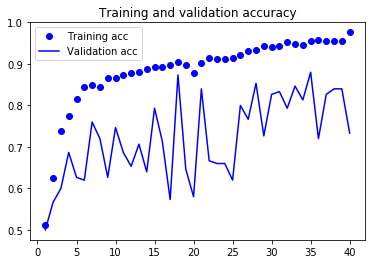

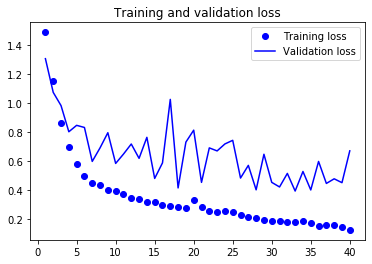

In [308]:
draw_evolution(history)

In [306]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 4s 4s/step - loss: 0.6405 - accuracy: 0.7436


[0.6404839158058167, 0.74358976]

In [307]:
name_of_model = 'Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74\assets


'./Models\\Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74'

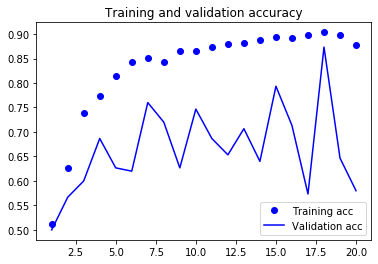

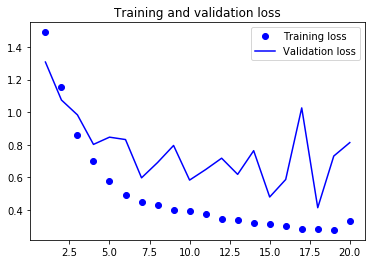

In [301]:
draw_evolution(history)

In [299]:
model.evaluate(eval_gen)

1/1 [==============================] - 16s 16s/step - loss: 0.4082 - accuracy: 0.8289


[0.4082433879375458, 0.82887703]

In [300]:
name_of_model = 'Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval\assets


'./Models\\Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval'

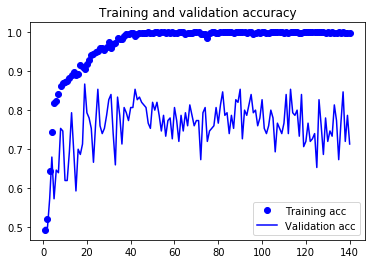

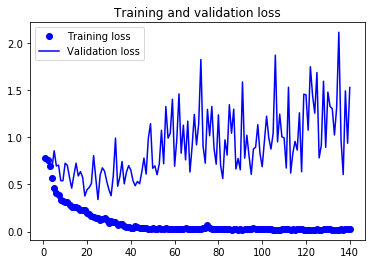

In [290]:
draw_evolution(history)

In [289]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.1653 - accuracy: 0.7133


[1.1653262476126354, 0.7133333]

In [291]:
name_of_model = 'Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71\assets


'./Models\\Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71'

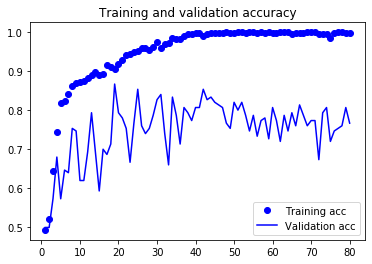

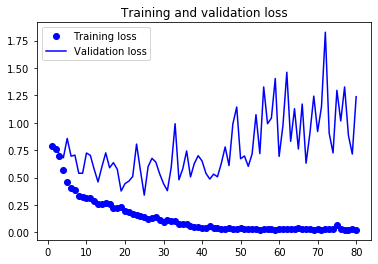

In [287]:
draw_evolution(history)

In [285]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.0238 - accuracy: 0.7667


[1.0237860282262166, 0.76666665]

In [286]:
name_of_model = 'Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76\assets


'./Models\\Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76'

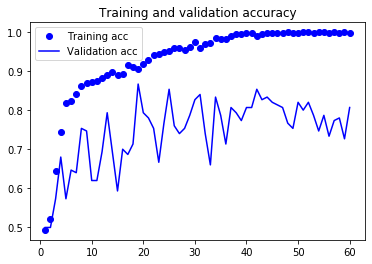

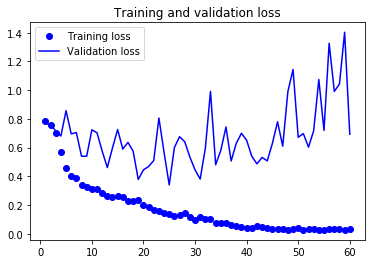

In [283]:
draw_evolution(history)

In [281]:
model.evaluate(eval_gen)

3/3 [==============================] - 7s 2s/step - loss: 0.6171 - accuracy: 0.8067


[0.6170507669448853, 0.8066667]

In [282]:
name_of_model = 'Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80\assets


'./Models\\Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80'

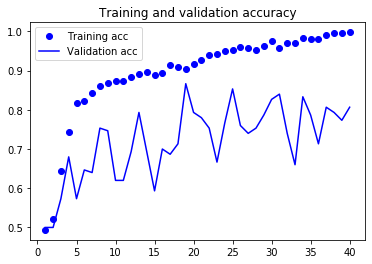

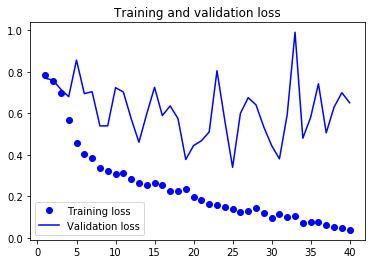

In [279]:
draw_evolution(history)

In [276]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 0.5712 - accuracy: 0.8067


[0.5712093114852905, 0.8066667]

In [277]:
name_of_model = 'Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80\assets


'./Models\\Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80'

In [272]:
model.evaluate(eval_gen)

3/3 [==============================] - 7s 2s/step - loss: 0.4233 - accuracy: 0.7933


[0.423296978076299, 0.79333335]

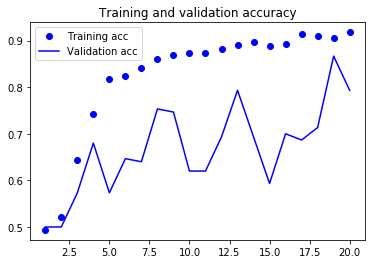

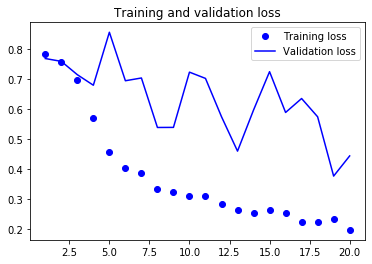

In [273]:
draw_evolution(history)

In [274]:
name_of_model = 'Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79\assets


'./Models\\Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79'

In [266]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.0644 - accuracy: 0.7400


[1.0643738905588787, 0.74]

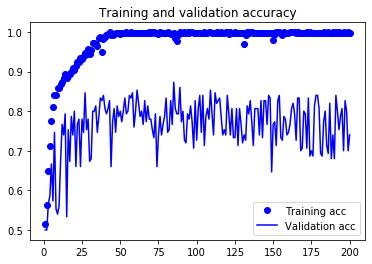

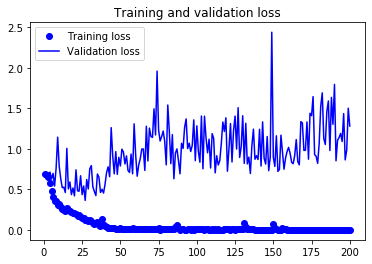

In [267]:
draw_evolution(history)

In [268]:
name_of_model = 'Model_5_512_0001_ep200_shuffle_bch64_acc74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_ep200_shuffle_bch64_acc74\assets


'./Models\\Model_5_512_0001_ep200_shuffle_bch64_acc74'

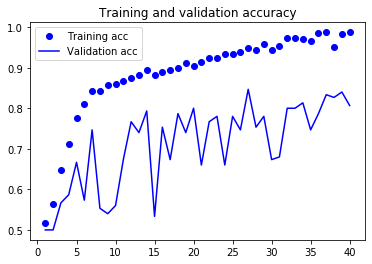

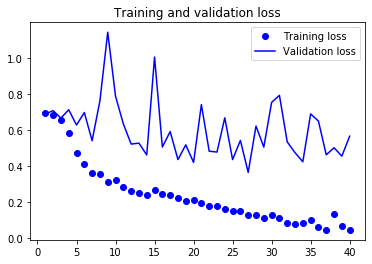

In [264]:
draw_evolution(history)

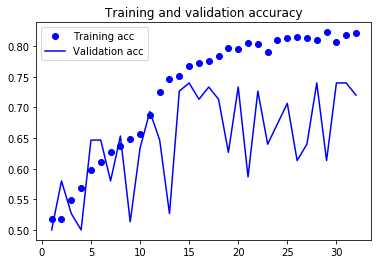

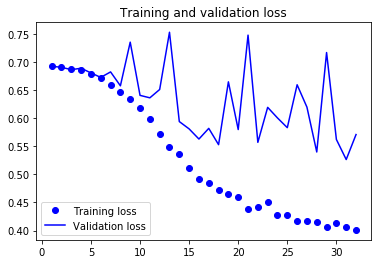

In [258]:
draw_evolution(history)

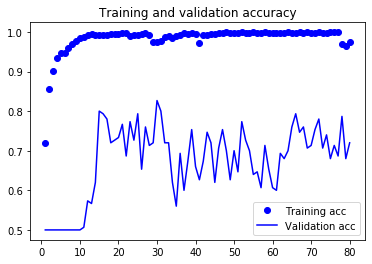

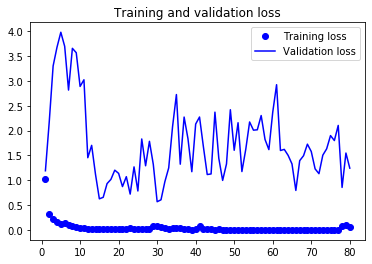

In [255]:
draw_evolution(history)

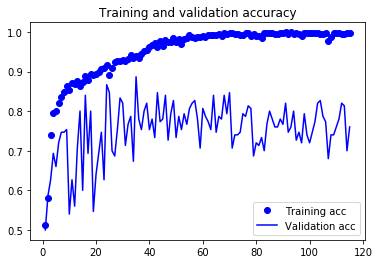

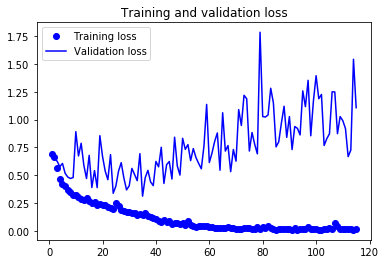

In [252]:
draw_evolution(history)

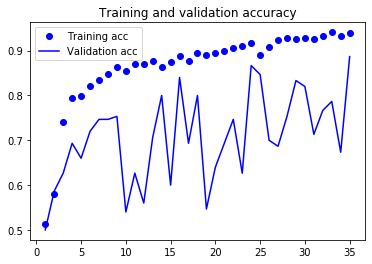

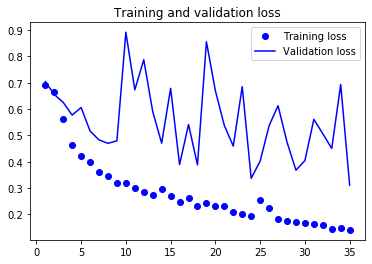

In [249]:
draw_evolution(history)

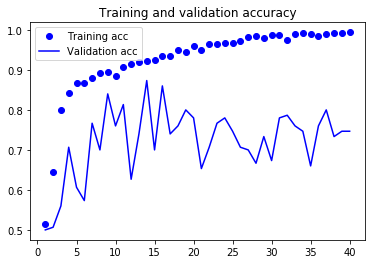

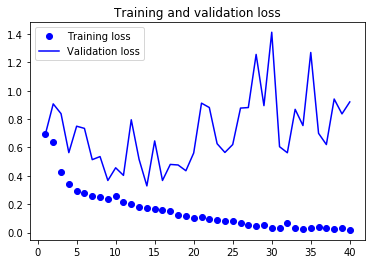

In [243]:
draw_evolution(history)

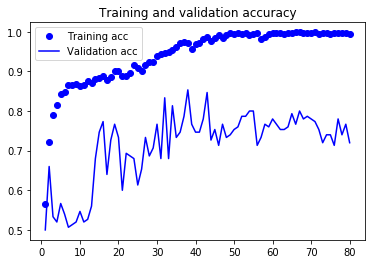

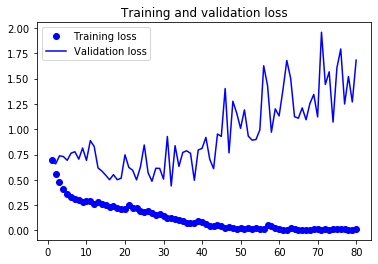

In [250]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 0.4134 - accuracy: 0.7933


[0.41340405742327374, 0.79333335]

In [240]:
name_of_model = 'Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72\assets


'./Models\\Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72'

In [ ]:
name_of_model = 'Model_5_dr05_512_0007_ep80_bch128_acc84'


In [223]:
eval_gen = GetGenerator(test_df,TEST_DIR,bs = 1)

Found 150 validated image filenames belonging to 2 classes.


In [224]:
for i in range(140):
    img = iter(eval_gen).next()

In [225]:
img[1]

array([1.], dtype=float32)

In [199]:
img = img[0][0,:,:,:]

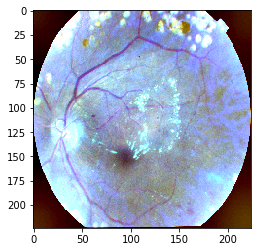

In [228]:
plt.imshow(img[0][0])

In [229]:
layer_outputs = [layer.output for layer in model.layers[:10]]
activation_model = tf.keras.models.Model(inputs = model.input, outputs=layer_outputs)

In [230]:
activations = activation_model.predict(img[0])

In [231]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 222, 222, 32)


(1, 5, 5, 512)


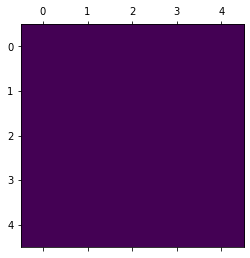

In [232]:
first_layer_activation = activations[9]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0,:,:,0],cmap = 'viridis')

C:\Users\PLDD\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


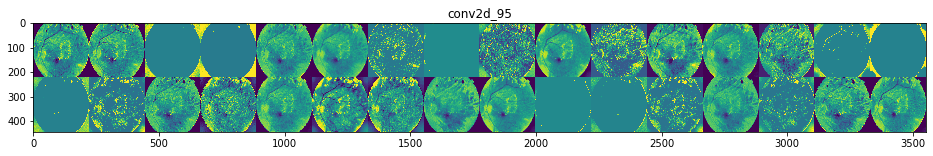

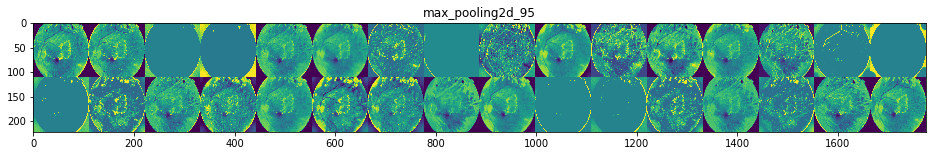

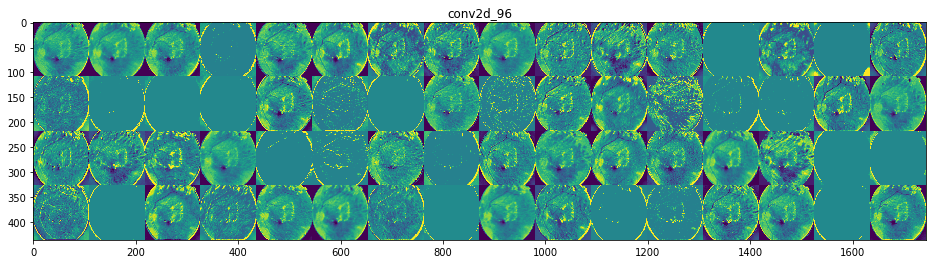

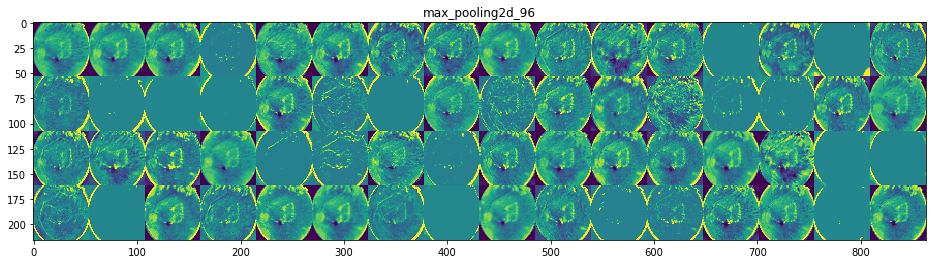

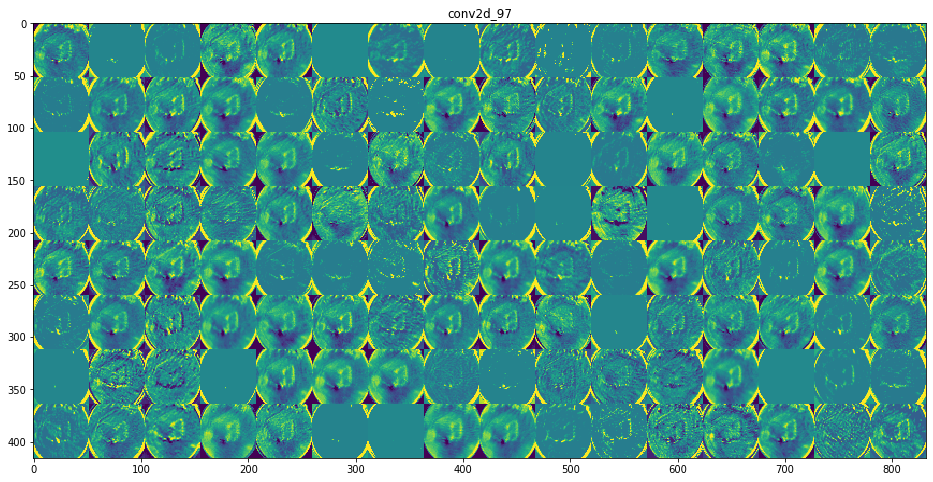

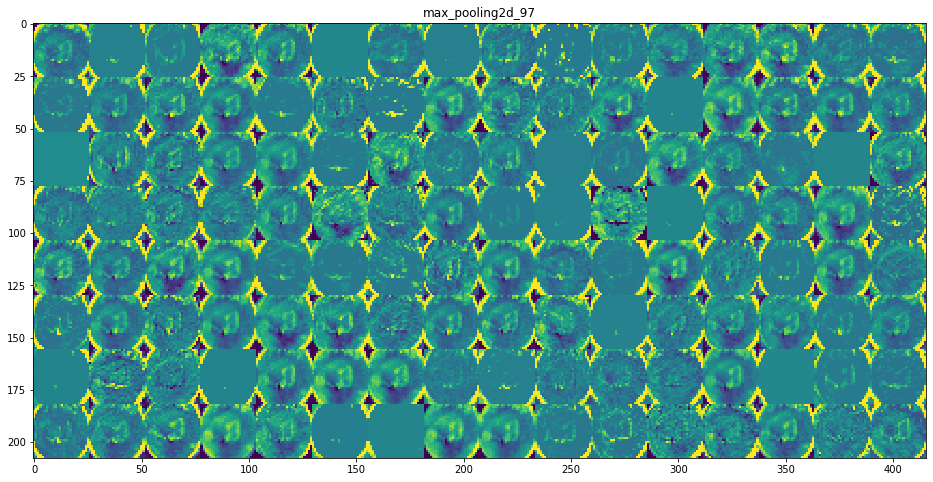

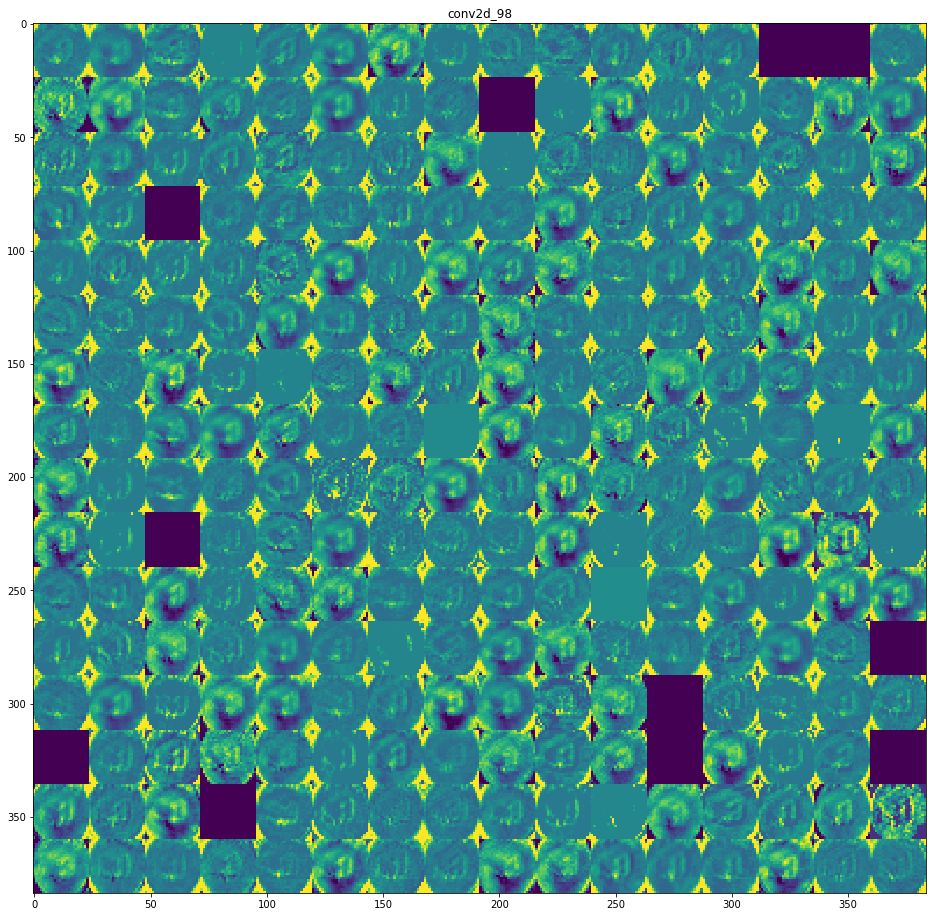

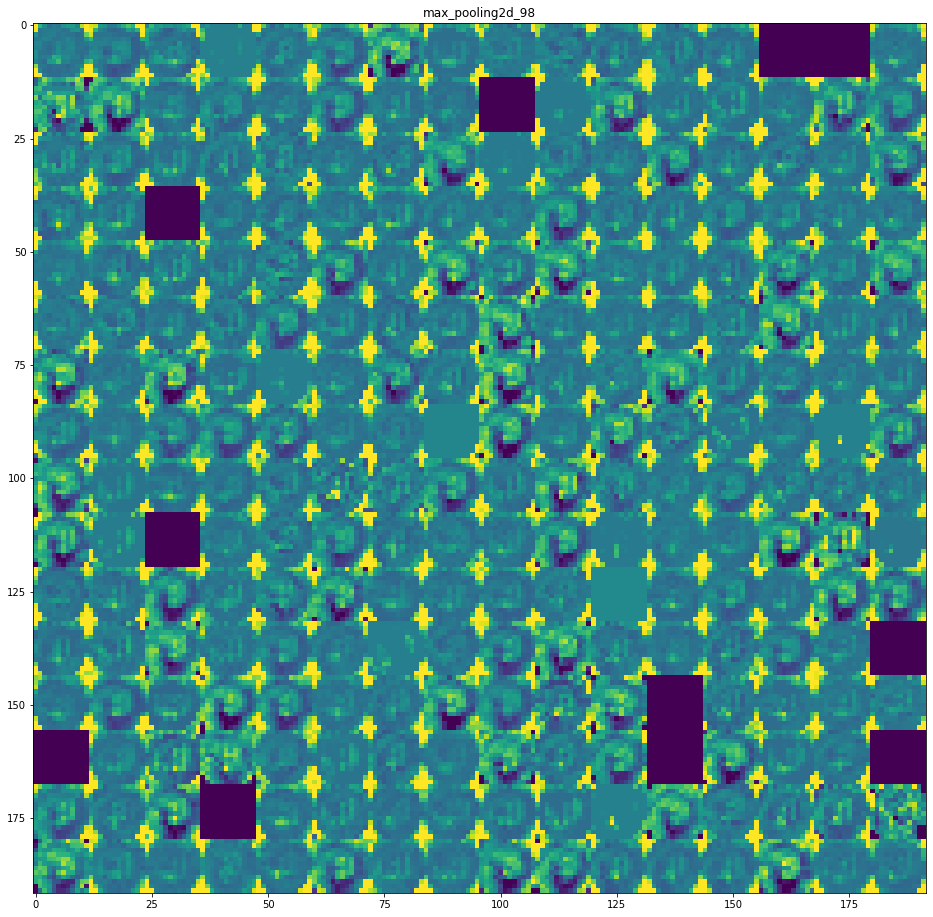

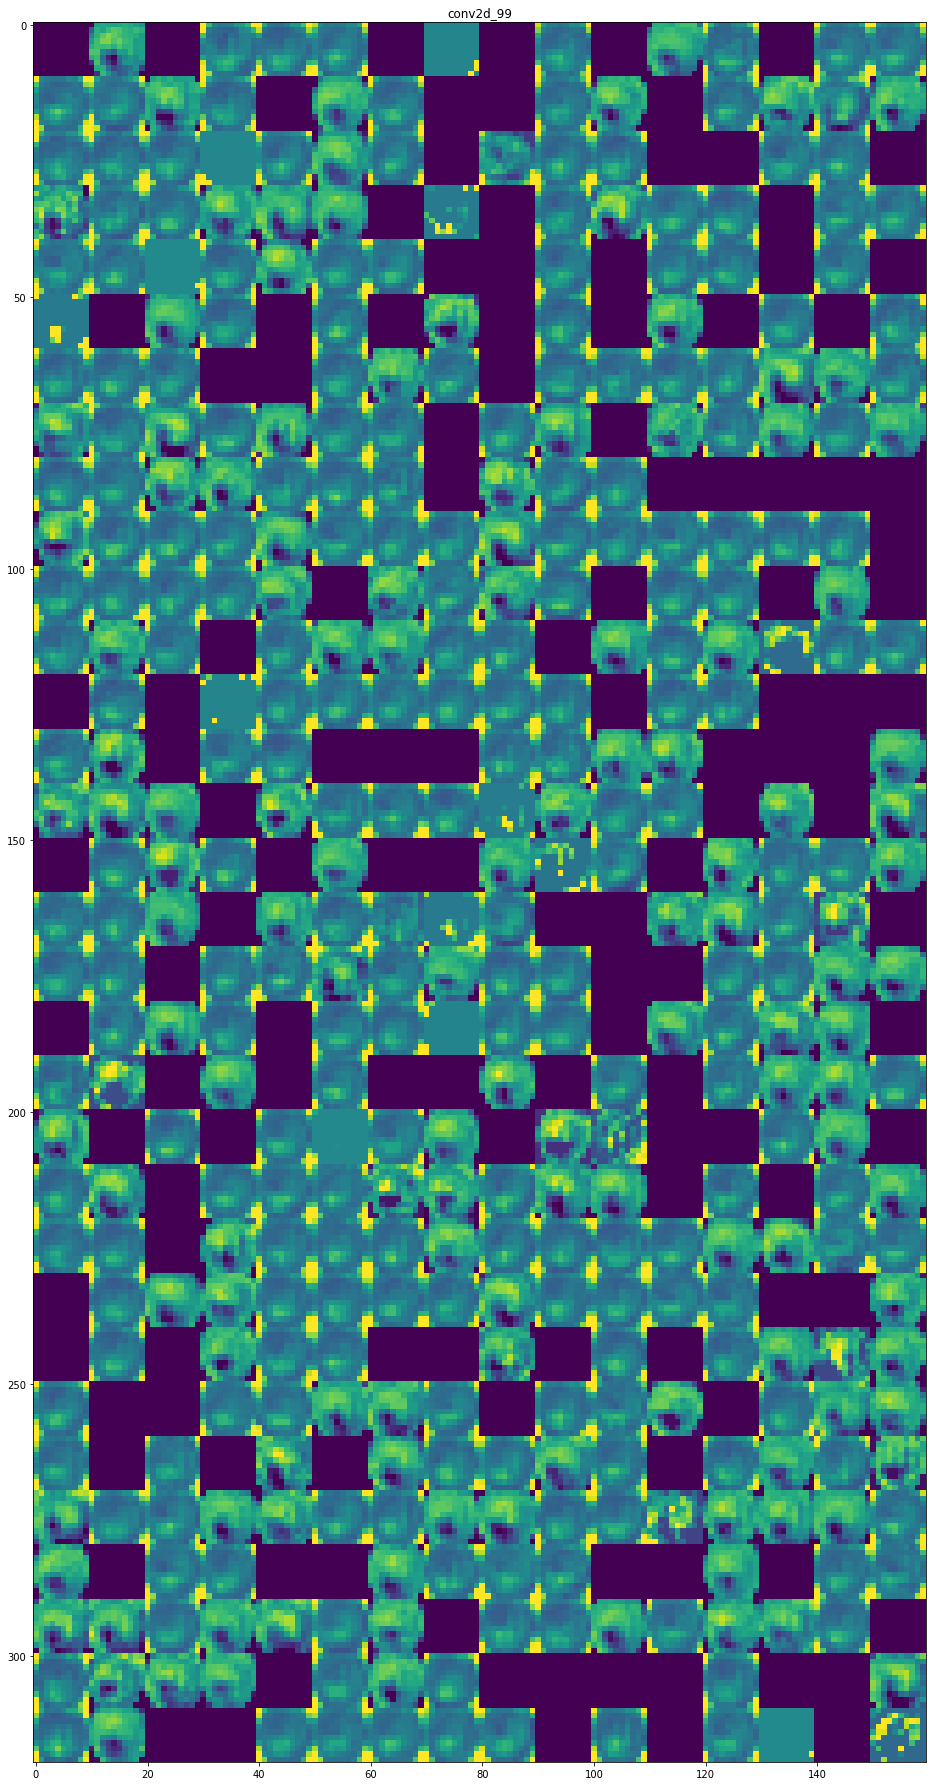

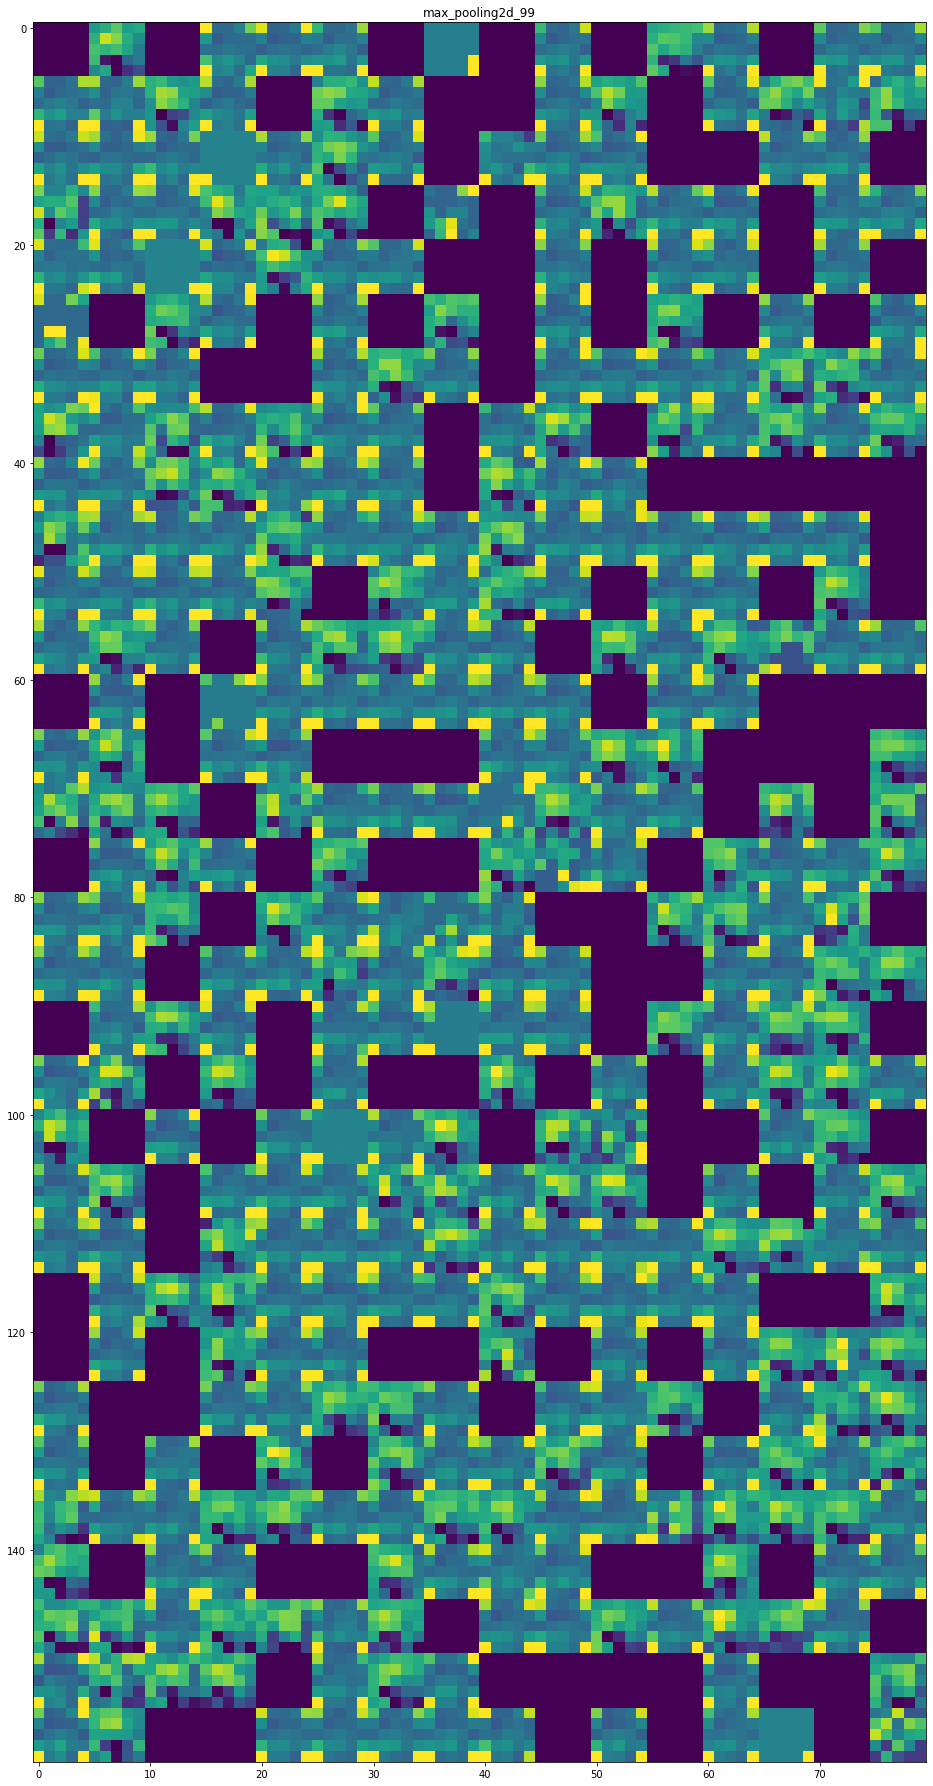

In [233]:
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize = (scale*display_grid.shape[1],
                         scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap = 'viridis')

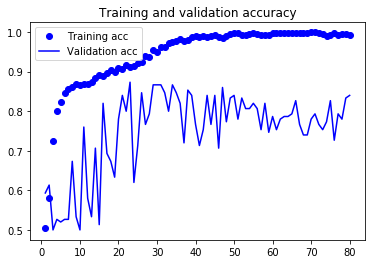

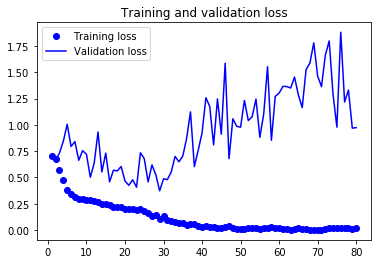

In [117]:
draw_evolution(history)

3/3 [==============================] - 8s 3s/step - loss: 0.7538 - accuracy: 0.8400


[0.7537725369135538, 0.84]

INFO:tensorflow:Assets written to: ./Models\Model_5_dr05_512_0007_ep80_bch128_acc84\assets


'./Models\\Model_5_dr05_512_0007_ep80_bch128_acc84'